In [70]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torch.nn as nn
from torchvision.transforms import v2
import multiprocessing

In [71]:
# run variables

seed = 42
file_name = 'base2'
epochs = 30

class BaseNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BaseNN, self).__init__()
        
        ### teacher2
        self.features = nn.Sequential( # [3, 32, 32]
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # [32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), # [32, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # [32, 16, 16]
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # [64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # [64, 16, 16]
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2), # [64, 8, 8]
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # [128, 8, 8]
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # [128, 8, 8]
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # [128, 8, 8]
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2), # [128, 4, 4]
            nn.Dropout(0.3),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        # ### teacher
        # self.features = nn.Sequential(
        #     nn.Conv2d(3, 128, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(128, 64, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.Conv2d(64, 64, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 32, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        # )
        # self.classifier = nn.Sequential(
        #     nn.Linear(2048, 512),
        #     nn.ReLU(),
        #     nn.Dropout(0.1),
        #     nn.Linear(512, num_classes)
        # )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [72]:
# device settings

num_workers = multiprocessing.cpu_count() // 2

print(torch.cuda.get_device_name(torch.cuda.current_device()))

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

AMD Radeon RX 7800 XT
Using cuda device


In [73]:
# define datasets and loaders

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = torchvision.datasets.CIFAR10("./../data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10("./../data", train=False, transform=transform, download=True)

train_dataset, validation_dataset =  random_split(train_dataset, [0.8, 0.2])

print('train set size:', len(train_dataset))
print('validation set size:', len(validation_dataset))
print('test set size:', len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=num_workers)

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

train set size: 40000
validation set size: 10000
test set size: 10000


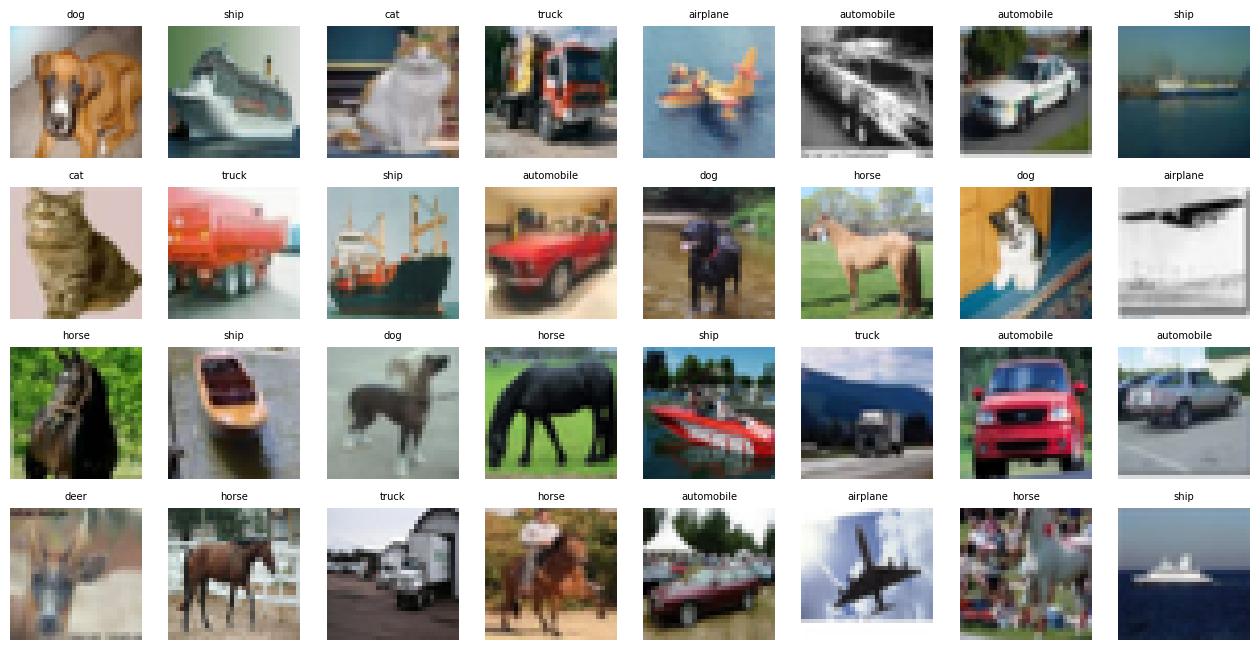

In [74]:
# show example data

exampleTransform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ])
exampleTrainDataset = torchvision.datasets.CIFAR10("./../data", train=True, transform=exampleTransform, download=True)
exampleTrainLoader = DataLoader(exampleTrainDataset, batch_size=32, shuffle=True, num_workers=num_workers)

for images_batch, labels_batch in exampleTrainLoader:
    plt.figure(figsize=(16,8))
    plt.rc('font', size=6)

    for index in range(32):
        plt.subplot(4,8,index+1)
        plt.imshow(images_batch[index].squeeze().permute(1,2,0))
        plt.title(class_names[labels_batch[index]])
        plt.axis('off')

    
    plt.ioff()
    plt.show()
    break

In [75]:
def train(model, epochs, learning_rate):
    trainingEpoch_loss = []
    validationEpoch_loss = []
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        # training
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        trainingEpoch_loss.append(running_loss / len(train_loader))

        # validation
        model.eval()
        validation_loss = 0.0
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item()

        validationEpoch_loss.append(validation_loss / len(validation_loader))
        
    return trainingEpoch_loss, validationEpoch_loss

In [76]:
def test(model):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [77]:
torch.manual_seed(seed)
model_base = BaseNN(num_classes=10).to(device)


In [78]:
trainingEpoch_loss, validationEpoch_loss = train(model_base, epochs=epochs, learning_rate=0.001)

Epoch 1/30, Loss: 1.766347521791062
Epoch 2/30, Loss: 1.3585173748552608
Epoch 3/30, Loss: 1.157435421555187
Epoch 4/30, Loss: 1.04708379697495
Epoch 5/30, Loss: 0.96561061231473
Epoch 6/30, Loss: 0.8992682455446773
Epoch 7/30, Loss: 0.8541852835649119
Epoch 8/30, Loss: 0.8077668741869088
Epoch 9/30, Loss: 0.7818775317920282
Epoch 10/30, Loss: 0.7553844962257166
Epoch 11/30, Loss: 0.7389889726052269
Epoch 12/30, Loss: 0.7166516211467048
Epoch 13/30, Loss: 0.6905140239781085
Epoch 14/30, Loss: 0.677809718413094
Epoch 15/30, Loss: 0.6660889405221604
Epoch 16/30, Loss: 0.6519047841667748
Epoch 17/30, Loss: 0.6444845845143254
Epoch 18/30, Loss: 0.6334975139020731
Epoch 19/30, Loss: 0.6257377154530047
Epoch 20/30, Loss: 0.614314497088472
Epoch 21/30, Loss: 0.6105377576031243
Epoch 22/30, Loss: 0.5961104832327785
Epoch 23/30, Loss: 0.5925487883555622
Epoch 24/30, Loss: 0.5904750757324048
Epoch 25/30, Loss: 0.5850192006594076
Epoch 26/30, Loss: 0.5857989331975151
Epoch 27/30, Loss: 0.58338130

2m 17s

In [79]:
test(model_base)

Test Accuracy: 80.62%


80.62

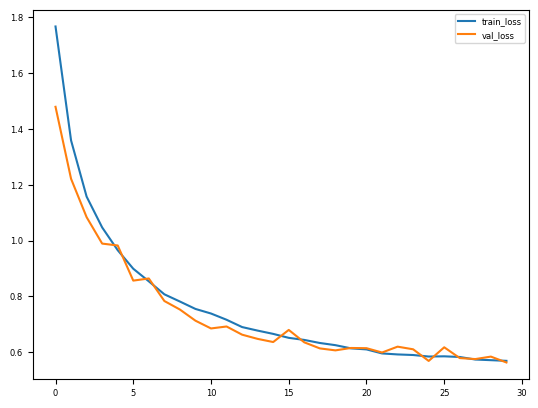

In [80]:
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
# plt.ylim(top=2)
plt.show()

In [81]:
torch.save(model_base.state_dict(), "../models/" + file_name + ".pt")